In [1]:
import os
current_dir = os.getcwd()
os.chdir("../../codes/")

In [2]:
# set seeds
import numpy as np
import random
import torch

seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from src.models import ResNet18
m = ResNet18()

model = m.get_model()

Loaded default imagenet-pretrained model: https://huggingface.co/timm/resnet18d.ra2_in1k


In [4]:
os.chdir(current_dir)

In [5]:
import numpy as np
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

path_image = 'n01440764_1185.JPEG'

rgb_img = cv2.imread(path_image, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.461, 0.461, 0.461],
                                    std=[0.219, 0.219, 0.219])

In [6]:
import torch
from skimage import segmentation
model = model.to('cpu')
input_tensors = torch.concat([input_tensor, input_tensor], 0)
baselines = torch.zeros_like(input_tensors)
targets =model(input_tensors).max(1).indices
feature_masks = torch.Tensor([
    segmentation.slic(input_tensor.clone().detach().cpu().numpy().squeeze().transpose((1, 2, 0)), n_segments=50, start_label=0)
    for input_tensor in input_tensors
]).int()
baselines.shape, feature_masks.shape, input_tensors.shape

C:\Users\matem\AppData\Local\Temp\ipykernel_16312\1785711237.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  feature_masks = torch.Tensor([


(torch.Size([2, 3, 224, 224]),
 torch.Size([2, 224, 224]),
 torch.Size([2, 3, 224, 224]))

In [7]:
from matplotlib import pyplot as plt
from captum.attr import KernelShap

model = model.to('cuda')
kernelshap = KernelShap(model)

In [8]:
def get_image_attr(STEPS=50, input_tensors=input_tensors, targets=targets, baselines=baselines, feature_masks=feature_masks):
    input_tensor = input_tensors[0].unsqueeze(0)
    target = targets[0].unsqueeze(0)
    baseline = baselines[0].unsqueeze(0)
    feature_mask = feature_masks[0].unsqueeze(0)
    attributions = kernelshap.attribute(input_tensor.to('cuda'), target=target.to('cuda'), baselines=baseline.to('cuda'), n_samples=STEPS, feature_mask=feature_mask.to('cuda'))
    # print('IG Attributions:', attributions.shape)
    results = attributions.cpu().detach().numpy().sum(axis=1)
    results = (results - np.min(results)) / (np.max(results) - np.min(results))
    return results

In [9]:
from tqdm import tqdm

# run get_image_attr() 3 times for STEPS = 25, 50, 100, 200, 300, 400, 500
# save results to a dictionary
# plot the results in a single plot side by side

def plot_attr(steps_list, repetitions, figsize=(10, 10), rgb_img=rgb_img, output_filename="output", show_plots=True):
    results = {
        steps: [get_image_attr(steps) for _ in range(repetitions)]
        for steps in tqdm(steps_list)
    }
    if show_plots:
        # raw explanation
        fig, axs = plt.subplots(len(steps_list), repetitions, figsize=figsize)
        for i, steps in enumerate(steps_list):
            for j in range(repetitions):
                axs[i, j].imshow(results[steps][j].sum(0), cmap='bwr', interpolation='nearest')
                axs[i, j].axis('off')
                axs[i, j].set_title(f'Steps: {steps}')
        plt.tight_layout()
        plt.savefig(f"{output_filename}.png")
        plt.show()
        # # explanation with background image
        fig, axs = plt.subplots(len(steps_list), repetitions, figsize=figsize)
        for i, steps in enumerate(steps_list):
            for j in range(repetitions):
                ex_img = show_cam_on_image(rgb_img, -1 * results[steps][j].sum(0))
                axs[i, j].imshow(ex_img)
                axs[i, j].axis('off')
                axs[i, j].set_title(f'Steps: {steps}')
        plt.tight_layout()
        plt.savefig(f"{output_filename}_with_image.png")
        plt.show()

100%|██████████| 7/7 [04:12<00:00, 36.00s/it]


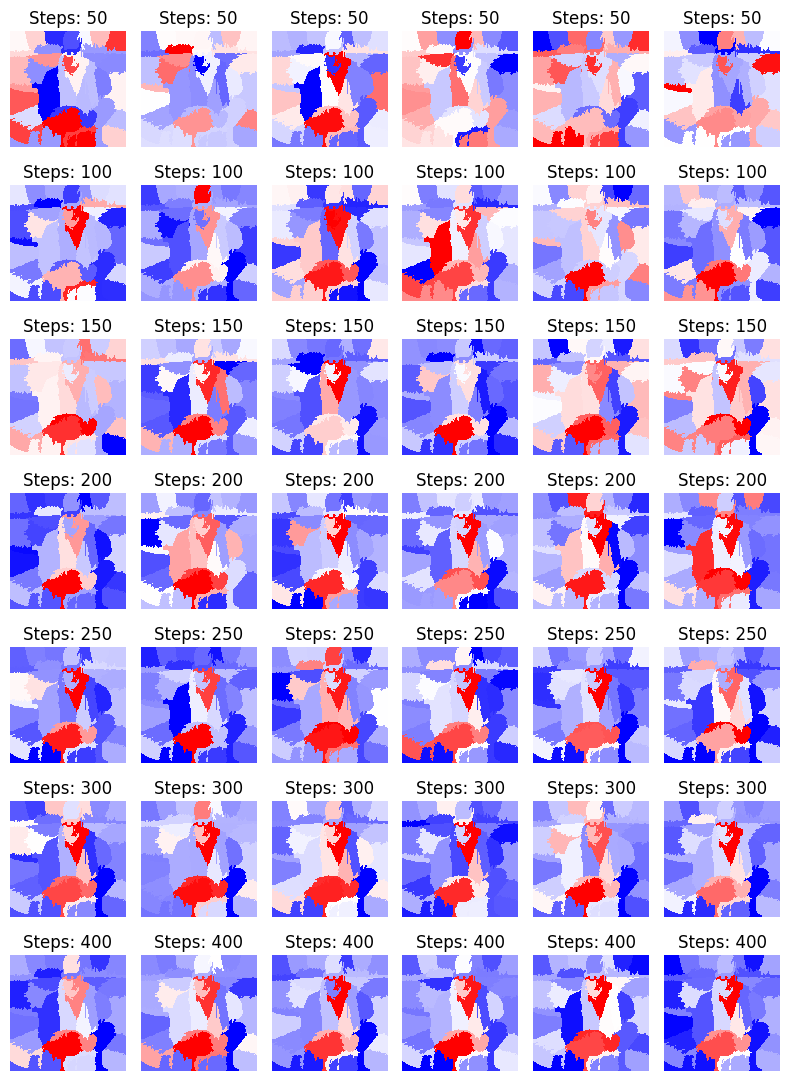

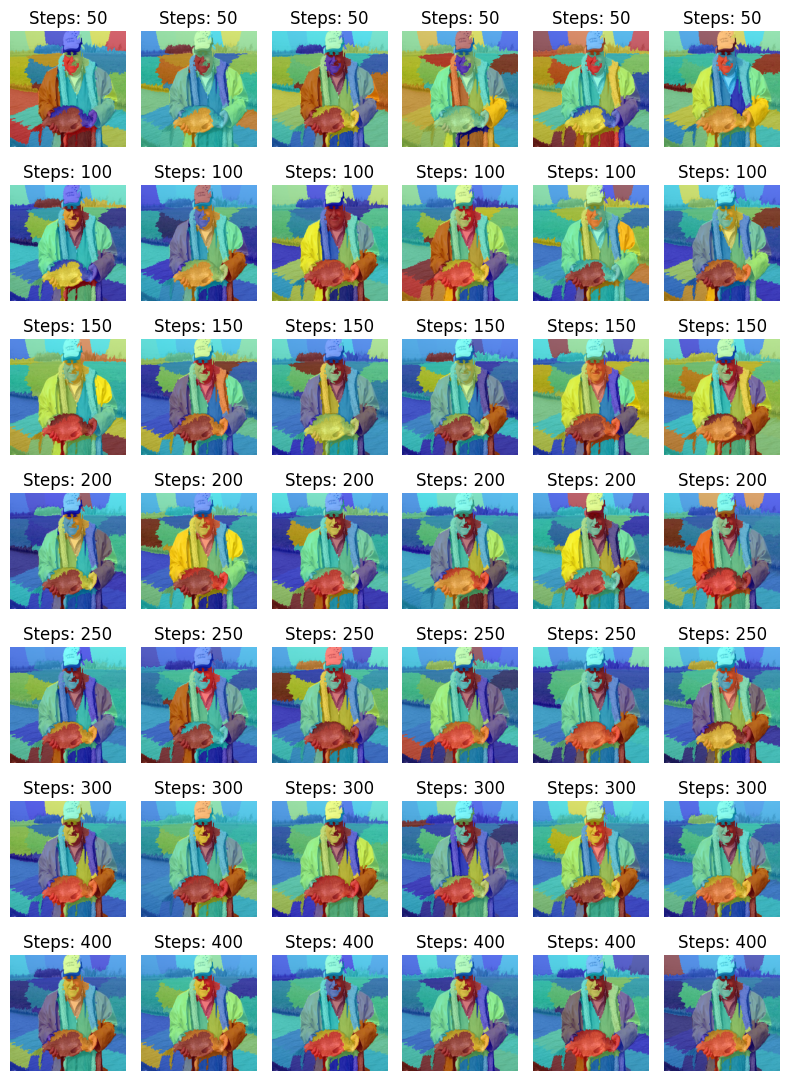

In [10]:
plot_attr([50, 100, 150, 200, 250, 300, 400], 6, figsize=(8, 11), output_filename="output")

Computation times on MX230, should be proportional to the number of steps.

In [11]:
import time
times = {}

# for steps in [2,3,5,10]:
for steps in [50, 100, 150, 200, 250, 300, 400]:
    print(f"Steps: {steps}")
    time_before = time.time()
    get_image_attr(steps)
    get_image_attr(steps)
    get_image_attr(steps)
    time_after = time.time()
    duration = (time_after - time_before) / 3
    print(f"Time taken: {duration:.2f}s")
    times[steps] = round(duration, 1)

print("\n\nSteps\tTime [s]")
for k, v in times.items():
    print(f"{k}\t{v}")

Steps: 50
Time taken: 1.19s
Steps: 100
Time taken: 2.65s
Steps: 150
Time taken: 4.72s
Steps: 200
Time taken: 5.77s
Steps: 250
Time taken: 6.05s
Steps: 300
Time taken: 8.69s
Steps: 400
Time taken: 10.65s


Steps	Time [s]
50	1.2
100	2.6
150	4.7
200	5.8
250	6.0
300	8.7
400	10.6


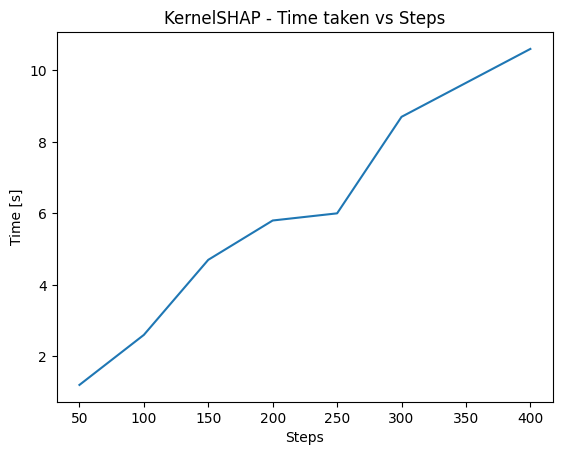

In [12]:
plt.plot(list(times.keys()), list(times.values()))
plt.xlabel("Steps")
plt.ylabel("Time [s]")
plt.title("KernelSHAP - Time taken vs Steps")
plt.savefig("time_vs_steps.png")
plt.show()